In [18]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
# Load and clean the dataset
data = pd.read_csv("Twitter Hate Speech - Twitter Hate Speech.csv")

def clean_tweet(tweet):
    tweet = re.sub(r'@user', '', tweet)
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    tweet = re.sub(r'\\x[\w]{2,}', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = tweet.lower()
    return tweet

data['cleaned_tweet'] = data['tweet'].apply(clean_tweet)

# Handle class imbalance
majority = data[data.label == 0]
minority = data[data.label == 1]
minority_upsampled = resample(minority,
                              replace=True, # Sample with replacement
                              n_samples=len(majority), # Match number in majority class
                              random_state=42) # Reproducible results

upsampled_data = pd.concat([majority, minority_upsampled])

In [ ]:
# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    upsampled_data['cleaned_tweet'], upsampled_data['label'], test_size=0.1, random_state=42
)

In [ ]:
# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)


In [ ]:

# Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HateSpeechDataset(train_encodings, train_labels.tolist())
val_dataset = HateSpeechDataset(val_encodings, val_labels.tolist())

In [ ]:

# Model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,              
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    use_cpu=True                     # Ensures use of CPU
)

In [11]:

# Define compute metrics function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\omarb\PythonLab\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.085400,0.037614,0.991588,0.991639,0.984069,0.999326
2,0.000200,0.035623,0.993775,0.993803,0.987683,1.000000
3,0.055900,0.024214,0.996467,0.996474,0.992972,1.000000


{'eval_loss': 0.024213574826717377, 'eval_accuracy': 0.9964670255720054, 'eval_f1': 0.9964735516372797, 'eval_precision': 0.9929718875502008, 'eval_recall': 1.0, 'eval_runtime': 290.2535, 'eval_samples_per_second': 20.479, 'eval_steps_per_second': 0.32, 'epoch': 3.0}


Normalized Confusion Matrix:
[[0.99294592 0.00705408]
 [0.         1.        ]]


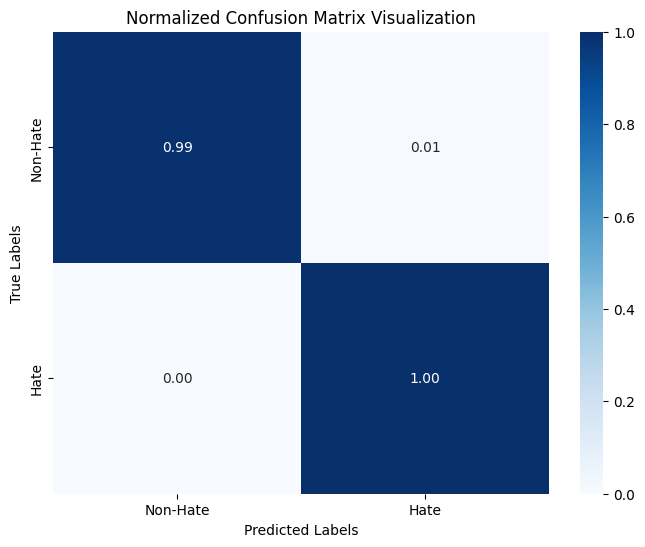

In [19]:
predictions = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)

cm = confusion_matrix(val_labels, pred_labels)

# Normalize the confusion matrix by dividing each row by its total
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the confusion matrix
print("Normalized Confusion Matrix:")
print(cm_normalized)

# Plotting the normalized confusion matrix with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Normalized Confusion Matrix Visualization')
plt.show()